In [9]:
import warnings
warnings.filterwarnings("ignore")

from data_loader import DataLoader
from models import MODELS
from misc.evaluation_metrics import *
from attacks import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [10]:
dl = DataLoader()
info = dl.get_info()

display(info)

,name,frequency,description,source,path
0,Electricity Transformer Data - 15 min,fifteen minutes,...,https://github.com/zhouhaoyi/ETDataset,data/electricity_transformer_15min.csv
1,Metro Interstate Human Traffic Volume,hour,Hourly Interstate 94 Westbound traffic volume ...,https://archive.ics.uci.edu/ml/datasets/Metro+...,data/Metro_Interstate_Traffic_Volume.csv
2,Beijing-Guanyuan Air-Quality,hour,This hourly data set considers 6 main air poll...,https://archive.ics.uci.edu/ml/datasets/Beijin...,data/beijing_air_quality_Data_Guanyuan_2013030...
3,Solar Generation - EnerjiSA,hour,Solar generation data of unlicenced solar cen...,https://www.kaggle.com/competitions/enerjisa-e...,data/enerjisa_solar_generation.csv


In [11]:
df = dl.load(3)
(X_train, y_train, X_test, y_test), scaler = dl.prepare_dataset(23*4,1)

print(dl.last_loaded_info["name"])
print(X_train.shape)
print(X_test.shape)
print()

# model = MODELS[-1]((X_train.shape[1],X_train.shape[2]), 1)

model = Sequential()
model.add(LSTM(32,activation="tanh", input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.15))
model.add(Dense(1))
model.summary()
model.compile(optimizer="adam",loss="MSE")

# train LSTM model
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10)

Solar Generation - EnerjiSA
(17826, 92, 1)
(7641, 92, 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
558/558 [==============================] - 4s 5ms/step - loss: 0.0163
Epoch 2/10
558/558 [==============================] - 3s 5ms/step - loss: 0.0055
Epoch 3/10
558/558 [==============================] - 3s 5ms/step - loss: 0.0039
Epoch 4/10
558/

In [12]:
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred).reshape(1,-1)[0]
y_test_inv = scaler.inverse_transform(y_test).reshape(1,-1)[0]


def SMAPE(true, pred):
    return np.mean((abs(true - pred) / ((abs(true) + abs(pred))/2))*100)

def MDAPE(true, pred):
    return np.median((abs(true - pred) / true)*100)


print("MAE :", np.mean(abs(y_test_inv - pred)))
print("RMSE :", RMSE(y_test_inv,pred))
print("MSE :", MSE(y_test_inv,pred))
print("MAPE :", MAPE(y_test_inv,pred))
print("SMAPE :", SMAPE(y_test_inv,pred))
print("MDAPE :", MDAPE(y_test_inv,pred))
print("R2 :", r2_score(y_test_inv,pred))

MAE : 8.261149920432535
RMSE : 12.472004232846798
MSE : 155.55088958414845
MAPE : 1384906.1003644285
SMAPE : 101.64186297259832
MDAPE : 103.75478560011517
R2 : 0.9918131494345325


In [13]:
fig = go.Figure(go.Line(y = y_test_inv, name="original"))
fig.add_trace(go.Line(y = pred, name="predicted"))
fig

# Adversarial Attacks

MAE : 20.834131368906444
RMSE : 26.02403585101362
MSE : 677.2504419748421
MAPE : 38.00387611738403
SMAPE : 113.4059761198693
R2 : 0.9643554069110906


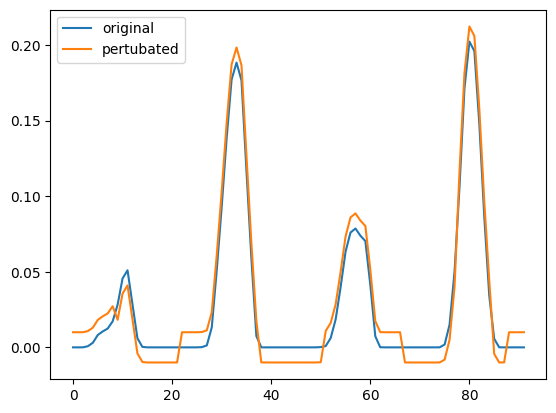

In [14]:
X_adversarial_fgsm = fgsm_attack(X_test, y_test, model, 0.01, np.inf)

pred = model.predict(X_adversarial_fgsm)
pred = scaler.inverse_transform(pred).reshape(1,-1)[0]
y_test_inv = scaler.inverse_transform(y_test).reshape(1,-1)[0]

print("MAE :", np.mean(abs(y_test_inv - pred)))
print("RMSE :", RMSE(y_test_inv,pred))
print("MSE :", MSE(y_test_inv,pred))
print("MAPE :", MAPE(y_test_inv[y_test_inv >= 10],pred[y_test_inv >= 10]))
print("SMAPE :", SMAPE(y_test_inv,pred))
print("R2 :", r2_score(y_test_inv,pred))

plt.plot(X_test[10], label = "original")
plt.plot(X_adversarial_fgsm.numpy()[10], label = "pertubated")
plt.legend()
plt.show()

MAE : 32.50120763110584
RMSE : 40.18896805619307
MSE : 1615.1531534217067
MAPE : 55.98242997794986
SMAPE : 122.70561153021868
R2 : 0.9149923376024548


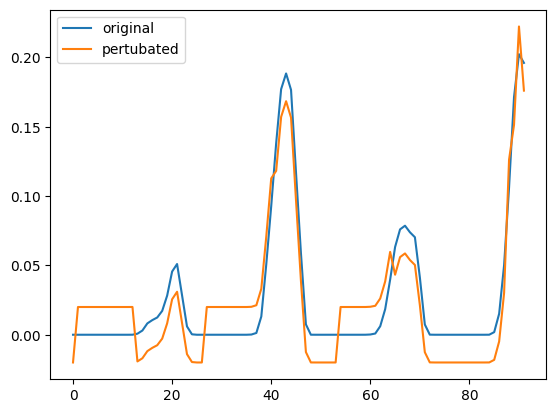

In [15]:
iterations = 10
alpha = 0.01
epsilon = 0.02
X_adversarial_pgd = pgd_attack(X_test, y_test, model, iterations, alpha, epsilon, np.inf)

pred = model.predict(X_adversarial_pgd)
pred = scaler.inverse_transform(pred).reshape(1,-1)[0]
y_test_inv = scaler.inverse_transform(y_test).reshape(1,-1)[0]

print("MAE :", np.mean(abs(y_test_inv - pred)))
print("RMSE :", RMSE(y_test_inv,pred))
print("MSE :", MSE(y_test_inv,pred))
print("MAPE :", MAPE(y_test_inv[y_test_inv >= 10],pred[y_test_inv >= 10]))
print("SMAPE :", SMAPE(y_test_inv,pred))
print("R2 :", r2_score(y_test_inv,pred))

plt.plot(X_test[0], label = "original")
plt.plot(X_adversarial_pgd.numpy()[0], label = "pertubated")
plt.legend()
plt.show()

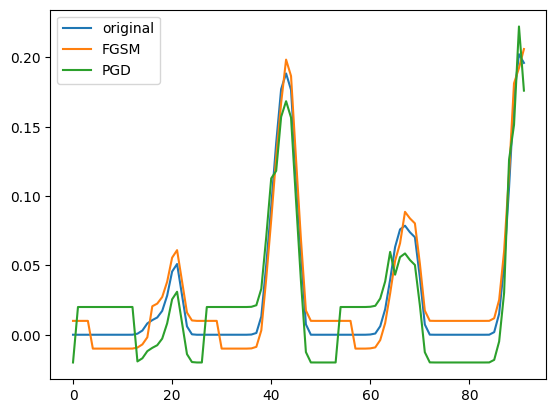

In [16]:
plt.plot(X_test[0], label = "original")
plt.plot(X_adversarial_fgsm.numpy()[0], label = "FGSM")
plt.plot(X_adversarial_pgd.numpy()[0], label = "PGD")
plt.legend()
plt.show()

In [ ]:
inp = tf.convert_to_tensor(X_test, dtype = tf.float32)
imgv = tf.Variable(inp)
with tf.GradientTape() as tape:
    tape.watch(imgv)
    predictions = model(imgv)
    loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
    grads = tape.gradient(loss,imgv)

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax1 = ax
ax2 = ax.twinx()

scaled_grad = (grads[0].numpy() - np.amin(grads[0].numpy())) / (np.amax(grads[0].numpy()) - np.amin(grads[0].numpy()))

# ax.plot(X_test[0], label = "original", color="red")
ax2.plot(tf.sign(grads[0]).numpy(), label = "signed", color="orange")
ax.plot(tf.sign(grads[0]).numpy()*scaled_grad, label = "signed", color="green")
plt.show()

# Cleverhans

In [ ]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

In [ ]:
X_adversarial_fgsm = fast_gradient_method(model, X_test, 0.1, 1)

pred = model.predict(X_adversarial_fgsm)
pred = scaler.inverse_transform(pred).reshape(1,-1)[0]
y_test_inv = scaler.inverse_transform(y_test).reshape(1,-1)[0]

print("MAE :", np.mean(abs(y_test_inv - pred)))
print("RMSE :", RMSE(y_test_inv,pred))
print("MSE :", MSE(y_test_inv,pred))
print("MAPE :", MAPE(y_test_inv[y_test_inv >= 10],pred[y_test_inv >= 10]))
print("SMAPE :", SMAPE(y_test_inv,pred))
print("R2 :", r2_score(y_test_inv,pred))

plt.plot(X_test[0], label = "original")
plt.plot(X_adversarial_fgsm.numpy()[0], label = "pertubated")
plt.legend()
plt.show()